# Routing Algorithm: OR-Tools

In this report we will show how to solve the Electric Vehicle Routing Problem (EVRP) using the open source package [*OR-Tools*](https://developers.google.com/optimization) from Google and the [Coin-OR Brunch-and-Cut](https://projects.coin-or.org/Cbc) suite. As compared to CPLEX, there are no mayor restrictions in the number of variables and constraints. This means that more charge columns can be considered during the optimization process. Furthermore, it is free.

In this notebook we will explain the differences between both optimizers and finally compare the results with those of A Better Route Planner (ABRP).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#OR-Tools" data-toc-modified-id="OR-Tools-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>OR-Tools</a></span><ul class="toc-item"><li><span><a href="#Indicator-constraints-vs.-Big-$M$-implementation" data-toc-modified-id="Indicator-constraints-vs.-Big-$M$-implementation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Indicator constraints vs. Big $M$ implementation</a></span></li><li><span><a href="#Piecewise-functions-and-SOS2-constraints" data-toc-modified-id="Piecewise-functions-and-SOS2-constraints-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Piecewise functions and SOS2 constraints</a></span></li></ul></li><li><span><a href="#Examples" data-toc-modified-id="Examples-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Examples</a></span><ul class="toc-item"><li><span><a href="#Hamburg-Dresden" data-toc-modified-id="Hamburg-Dresden-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Hamburg-Dresden</a></span></li><li><span><a href="#Dresden-Munich" data-toc-modified-id="Dresden-Munich-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Dresden-Munich</a></span></li><li><span><a href="#Dresden-Frankfurt" data-toc-modified-id="Dresden-Frankfurt-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Dresden-Frankfurt</a></span></li><li><span><a href="#Düsseldorf-Nürnberg" data-toc-modified-id="Düsseldorf-Nürnberg-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Düsseldorf-Nürnberg</a></span></li></ul></li><li><span><a href="#The-Overhead-parameter" data-toc-modified-id="The-Overhead-parameter-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The Overhead parameter</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

## OR-Tools

OR-Tools is an open source software suite for optimization, tuned for tackling problems in vehicle routing, flows, integer and linear programming, and constraint programming.

The way it works is that you model your problem in the programming language of your choice, and then choose a solver to solve it. One can in principle use CPLEX or any other supported commercial or open source solver. OR-Tools works as a middle man, an intermediary between your programming language and the solver you want to use. In this notebook we will use Coin-OR Branch and Cut (CBC), which is an open source solver specialized in Mixed Integer Linear Programming (MILP) which are the kind of problems that we face in our EVRP.

As compared to CPLEX, CBC is free and there are no constraints in the number of variables and constraints that one uses. As a reminder, the free version of CPLEX is limited to 1000 variables and 1000 constraints. Why is this important? Well, in our routing algorithm we use decision variables and constraints to optimize the route time and charges. For each node in our Graph model we have roughly:

$$\text{Variables} = 2×(\text{Arcs}+4×\text{Stations}+1)$$
and  
$$\text{Constraints} =2×\text{Arcs}+3×(2×\text{Stations}+1)$$

This imposes a limit on how many charging columns we can consider during the optimization process. In our [previous report](https://eclever.atlassian.net/wiki/spaces/ROUTE/pages/1297776641/Route+Algorithm%3A+Real+examples), for instance, we could only consider 35 columns, which can imply that we miss better solutions of the EVRP for a given route. 
Using OR-Tools and CBC removes this constraint without a cost.

However, this solver has some features missing that are easy to implement in solvers like CPLEX. This does not mean that we can can not do similar things, but this might come with a cost. This is what will discuss next.

### Indicator constraints vs. Big $M$ implementation

With CPLEX we were using what are called indicator constraints. These are used when one wants to enforce a constraint only if a previous condition is fulfilled. In our EVRP we were using indicator constraints in the following way:

If an arc $i,j$ is active, i.e., $x_{i,j}=1$ then the decision variable $q_{i,j} = E_{i,j}$. Where $E_{i,j}$ is the arc energy consumption taken from the Energy consumption matrix. 

This part of the algorithm is very important because here it decides if the arc $i,j$ will be taken (drive from $i$ to $j$) or not based on the battery restrictions.    

CBC does not implement indicator constraints, however, there is a mathematical trick known as the Big $M$ formulation, in which we can impose such *if-then* logic constraint by using a large constant $M$.

In our EVRP model the constraint has the following form:

$$
q_{i,j} \geq E_{i,j} - (1-x_{i,j})M
$$

So if $x_{i,j}=1 \implies q_{i,j} \geq E_{i,j}$. Whereas, if $x_{i,j}=0$ implies that $q_{i,j}$ must have a large negative value, but since this is not possible due to the bounds imposed on $q_{i,j}$ which must be between 0 and Q (The EV battery capacity), then this constraint does not apply.

Big-$M$ formulations are relatively straightforward, but the value of $M$ needs to be chosen carefully. If $M$ is smaller than the upper bound of $q$, this situation may cut off valid solutions. If $M$ is too large, the model may become numerically difficult.

Indicator constraints have the advantage of avoiding these types of problems, as they do not rely on a separate constant value.

### Piecewise functions and SOS2 constraints

Another feature which was easily implemented in CPLEX was the Piecewise linear function, which we need to model the charge columns charging curves. This feature is not available with CBC, however, Piecewise linear functions can be modeled using variables that satisfy what is known as a Special Order Set constraint of type 2 (SOS2).

Lets consider the following example: Given that we need to model the piecewise linear continuous function $y = f(x)$ specified by its $n$ node breaking points
 $(x_1, y_1)$, $(x_2, y_2)$, ... , $(x_n, y_n)$
 as shown below.
![piecewise](https://bitbucket.org/jhamannborrero/chargecurve/raw/b0963bea54b6d2369a4ae97f464acec2df7c324b/jupyter/piecewise.png) 
 
The standard description using an SOS2 constraint is the following:
+  $x = x_1 s_1+ x_2 s_2 + ...+ x_n s_n$

+  $y = y_1 s_1+ y_2 s_2 + ...+ y_n s_n$

+ $\sum_{i=1}^n s_i = 1$  

The set of variables { $s_1 , s_2 ,..., s_n$ }  play the role of interpolation parameters. 

In order for the Piecewise formulation to work properly, we need to impose the special SOS2 constraint on these $s$ variables. The restrictions are:

+ At most two of the $s_i$ can be nonzero.

+ Two nonzero $s_i$ must be adjacent.

The SOS2 restriction can be modeled using binary variables $z_i$:

+ $s_i \leq z_i$  

+ $\sum_{i=1}^n z_i \leq 2$

+ $z_i + z_j \leq 1,~ \forall~i,j~\in~n ~\text{if}~ i\neq j,j\neq i+1~\text{and}~i\lt j$

Note that the implication for using this approach is that we now need more parameters to determine the charging time at a charging column. 

As a reminder, to determine the time spent at a charge column during a charging event we need the EV battery charge when the EV enters a charging station ($C_{IN}$) and the charge state when it leaves the charge station ($C_{OUT}$). With these we can calculate the time spent during the charge  $\Delta t_{C} = t_{C ~\text{OUT}}-t_{C ~\text{IN}}$ . Where  $t_C=f_S(C)$  and  $f_S(C)$  is the Piecewise function at station  $S$. 

Since we are manually defining the Piecewise function $f_S(C)$ we will need for each charge station $S$ two functions, one to determine $t_{IN}$ and another one to determine $t_{OUT}$, hence increasing considerably the amount of variables and constraints imposed on our model.

OK, now that we know how to model our Piecewise functions using SOS2 constraints, and how to replace indicator constraints with the help of a big $M$ formulation we are now ready to write everything up and show some examples of EVRP solutions using OR-Tools.

## Examples

In this section we will reproduce the example routes we solve suing CPLEX in our previous report. These routes are:

+ Hamburg-Dresden
+ Dresden-Munich
+ Dresden-Frankfurt
+ Düsseldorf-Nürnberg

We will use the same methodology and the same functions we have used previously. As a reminder, these are the steps we follow in our algorithm:

1. Get desired from origin to destination route from Open Route Service (ORS).

2. Search for adequate charging columns along the route.

3. Generate data structure: Time, distance and energy consumption matrices.

4. Model the problem in OR-Tools and solve the EVRP.

5. Print the solution and retrieve final route with charging stops from ORS.

Before we continue, it is worth mention that for step 2, the algorithm has been optimized. What we now do is, each 5 km along the route, we search for columns in an area of $\sim 5\times5~km^2$. This reduces the amount of database queries and also the overlapping area is minimum, which optimizes the query performance. Below is an example of this new approach compared to the old one. As observed, the search areas of the new approach are larger than before and are evenly separated each 5 k, trying to keep the overlapping at a minimum. The old approach was doing more queries and having a larger areal overlap, which traduces in inefficient use of time resources.

In [1]:
import pandas as pd
import sys, warnings, datetime
sys.path.append('../chargecurve/')
warnings.filterwarnings('ignore')
from databases import query_vehicle, load_base2_ftp
from functions import getArcEnergy, get_peaks, collect_charges
from chargecurve import ChargingCurve, AutoCharge
from routing import queryRouteStations, getRouteData, getGeoDistance
import openrouteservice as ors
from openrouteservice import client
import folium 
import geopy.distance 
import psycopg2
import numpy as np
from scipy.interpolate import interp1d

# get route using the openrouteservice API
api_key = '5b3ce3597851110001cf62487d4fb586fbde48c4a1920afb15fe4220' #Provide your personal API key
clnt = client.Client(key=api_key) 

hamburg = (10.01534, 53.57532)
dresden = (13.737262,51.050407)

route = ors.directions.directions(clnt, coordinates=[hamburg, dresden], profile = 'driving-car',
                                      instructions=False)
#route geometry
geom = route['routes'][0]['geometry']

# extracts lat, lon and altitude
route_profile = pd.DataFrame(ors.convert.decode_polyline(geom,is3d=False)['coordinates'], 
                             columns=['long','lat'])

# determine location point separated each 5km
route_profile['s']= np.round(getGeoDistance(route_profile)[1])
_ = route_profile[route_profile.s % 5 == 0].drop_duplicates(subset='s', keep='first')

#plot route on map
line = route_profile[['lat','long']]

m = folium.Map(location=(51.407559,12.388356), zoom_start=10)

folium.vector_layers.PolyLine(locations=line).add_to(m)

# define the area at which the charge columns query is performed
delta = 0.02
for loc in _.index.values:

    square = [[route_profile.lat.loc[loc]-delta,route_profile.long.loc[loc]-2*delta], 
              [route_profile.lat.loc[loc]+delta,route_profile.long.loc[loc]-2*delta],
              [route_profile.lat.loc[loc]+delta,route_profile.long.loc[loc]+2*delta], 
              [route_profile.lat.loc[loc]-delta,route_profile.long.loc[loc]+2*delta],
              [route_profile.lat.loc[loc]-delta,route_profile.long.loc[loc]-2*delta]]

    folium.vector_layers.Rectangle(bounds=square, fill=True).add_to(m)

print('{:*^30}'.format(''))
print('{:*^30}'.format('New Approach'))
print('{:*^30}'.format(''))    
    
m

******************************
*********New Approach*********
******************************


In [2]:
print('{:*^30}'.format(''))
print('{:*^30}'.format('Old Approach'))
print('{:*^30}'.format(''))
m = folium.Map(location=(51.407559,12.388356), zoom_start=10)

folium.vector_layers.PolyLine(locations=line).add_to(m)

for loc in route_profile[::20].index.values:

    square = [[route_profile.lat.loc[loc]-delta,route_profile.long.loc[loc]-delta], 
              [route_profile.lat.loc[loc]+delta,route_profile.long.loc[loc]-delta],
              [route_profile.lat.loc[loc]+delta,route_profile.long.loc[loc]+delta], 
              [route_profile.lat.loc[loc]-delta,route_profile.long.loc[loc]+delta],
              [route_profile.lat.loc[loc]-delta,route_profile.long.loc[loc]-delta]]

    folium.vector_layers.Rectangle(bounds=square, fill=True).add_to(m)

m

******************************
*********Old Approach*********
******************************


Another important aspect we need to discuss is that, although, with OR-Tools we have now not major limitations regarding the amount of charging columns we can consider in our model, we still have a limitation coming from ORS. As mentioned already in our previous notebook, the distance matrix service from ORS allows a matrix query for a maximum of 57 locations. This limits again the amount of charge columns we can use in the modeling of the EVRP. This can be solved, in principle, by configuring OSR in our own server. Currently we can only use OSR from its web API, where their internal configuration has this limitation.

Let us now, formulate the problem using OR-Tools and solve the EVRP. 

In these examples, we will use the same EV (Hyundai Ioniq) as in the previous notebook, we keep the same driving condition, i.e., 110km/h, no rain, no wind, no add weight. We depart with 100% State of Carge (SoC), we enter a charging station with no less than 10% SoC and we want to arrive at destinations with 10% SoC.

Again we constraint the charging columns to be of type CCS and will use the same 50, 100, 150 and 350 kW charging curves we used in the [previous report](https://eclever.atlassian.net/wiki/spaces/ROUTE/pages/1297776641/Route+Algorithm%3A+Real+examples). Keep in mind that these are Piecewise functions fitted on real charging curves for the Ioniq, so we are considering a real life scenario, as we did before.

In [3]:
from ortools.linear_solver import pywraplp

def solveEVRP_ortools(arcs, stations, auto, soc_ini, soc_min, soc_end, overhead):

#    overhead = 10 # mins
    arcs = arcs.copy()
    nodes =  arcs['nodes']
    origin = 0
    destination = len(nodes)-1

    del arcs['nodes']
    
    Q = auto.nettoKwh[0]
    
    # big M to define indicator constraints
    M = 1000
    
    #initiate model
    model = pywraplp.Solver('EVRP', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    model.EnableOutput()
    # set a time limit to get a solution in miliseconds
    model.set_time_limit(30000)

    # define variables
    x = {arc:model.BoolVar('x[{}]'.format(arc)) for arc in arcs} 
    q = {arc:model.NumVar(0, Q, 'q[{}]'.format(arc)) for arc in arcs} 

    c_in = {i:model.NumVar(soc_min*Q, Q, 'c_in[{}]'.format(i)) for i in range(1,len(nodes))} 

    c_out = {i:model.NumVar(soc_min*Q, Q, 'c_out[{}]'.format(i)) for i in range(len(nodes)-1)} 

    t_in = {i:model.NumVar(0, 500, 't_in[{}]'.format(i)) for i in stations} 

    t_out = {i:model.NumVar(0, 500, 't_out[{}]'.format(i)) for i in stations} 

    # objective function
    model.Minimize(model.Sum(arcs[arc]['time']*x[arc] for arc in arcs)
                   + overhead*(model.Sum(x[arc] for arc in arcs) -1)
                   + model.Sum((t_out[i]-t_in[i]) for i in stations)
    #               + model.Sum((t_out[i]-t_in[i]) for (i,j) in x if x[(i,j)] == 1 and i!=0)
                  )
    
    # define constraints

    # consumption indicator constraint with big M formulation
    for arc in arcs:
        model.Add(q[arc] >= arcs[arc]['consumption'] - (1-x[arc])*M, 'C_{}'.format(arc))

    # exit flow 
    model.Add(model.Sum([x[0,j] for j in nodes if j !=0 and (0,j) in arcs]) == 1, 'flow0' )

    # continuous flow
    for i in stations:
        model.Add(model.Sum(x[(j,i)] for j in nodes if i!=j and (j,i) in arcs) 
                  == model.Sum(x[(i,j)] for j in nodes if i!=j and (i,j) in arcs), 'flow{}'.format(i)
                 )
    # how much to charge constraint
    for (i,j) in arcs:
        model.Add((c_out[i] - c_in[j]) == q[(i,j)],'')

    # initial and final battery level
    model.Add(c_out[origin] == soc_ini*Q, '')
    model.Add(c_in[destination] == soc_end*Q, '')

    # define piecewise functions for charger speeds
    pwf_ortools_params_dic = {50: [[  0.,  29.84061854,  79.00130959,  91.73437364,100.],
                                   [ 0., 15.46504219, 34.32467859, 43.45117686, 68.69722641]],
                              100: [[  0.,  22.52879574,  39.25771647,  40.58786094,100.],
                                    [ 0., 20.76008139, 25.63730618, 26.18398679, 42.55716897]],
                              150: [[  0.,  32.47273317,  75.39059379,  75.54804826,100.],
                                    [ 0., 11.57100678, 23.0430166 , 22.76026374, 34.99621425]],
                              350: [[  0.,  31.32698374,  78.54271751,  79.90956141,100.],
                                    [ 0.,  9.87999129, 23.30983567, 25.62739583, 34.1460323 ]]}

    curves = {i:{} for i in stations}

    def Piecewise1(s, params):

        bp_x = params[0]
        bp_y = params[1]

        n = len(bp_x)

        #variables
        curves[s]['z_in'] = {i:model.BoolVar('z_in_{}[{}]'.format(i,s)) for i in range(n)}
        curves[s]['s_in'] = {i:model.NumVar(0,1,'s_in_{}[{}]'.format(i,s)) for i in range(n)}

        curves[s]['z_out'] = {i:model.BoolVar('z_out_{}[{}]'.format(i,s)) for i in range(n)}
        curves[s]['s_out'] = {i:model.NumVar(0,1,'s_out_{}[{}]'.format(i,s)) for i in range(n)}

        #define SOS2 constraints
        for i in curves[s]['s_in']:
            model.Add(curves[s]['s_in'][i]<=curves[s]['z_in'][i],'')
            model.Add(curves[s]['s_out'][i]<=curves[s]['z_out'][i],'')
        model.Add(model.Sum(curves[s]['s_in'][i] for i in curves[s]['s_in']) == 1,'')
        model.Add(model.Sum(curves[s]['z_in'][i] for i in curves[s]['z_in']) <= 2,'')
        model.Add(model.Sum(curves[s]['s_out'][i] for i in curves[s]['s_out']) == 1,'')
        model.Add(model.Sum(curves[s]['z_out'][i] for i in curves[s]['z_out']) <= 2,'')
        for i in curves[s]['z_in']:
            for j in curves[s]['z_in']:
                if i!=j and j!= i+1 and i<j:
                    model.Add(curves[s]['z_in'][i]+curves[s]['z_in'][j]<=1,'')
                    model.Add(curves[s]['z_out'][i]+curves[s]['z_out'][j]<=1,'')

        model.Add(model.Sum(bp_x[i]*curves[s]['s_in'][i] for i in curves[s]['s_in']) == c_in[s]*100/Q,'')
        model.Add(model.Sum(bp_y[i]*curves[s]['s_in'][i] for i in curves[s]['s_in']) == t_in[s],'')
        model.Add(model.Sum(bp_x[i]*curves[s]['s_out'][i] for i in curves[s]['s_out']) == c_out[s]*100/Q,'')
        model.Add(model.Sum(bp_y[i]*curves[s]['s_out'][i] for i in curves[s]['s_out']) == t_out[s],'')

    for i in stations:
        Piecewise1(i,pwf_ortools_params_dic[stations[i]['power']])

    for i in stations:
        model.Add(t_out[i] >= t_in[i])

    # Solve EVRP
    solution = model.Solve()
    solution_type = {0:'Optimal', 1:'Feasible', 2: 'Infeasible', 6: 'Not Solved'}
    print('Solution: {}'.format(solution_type[solution]))
    
    # Print solution
    active_arcs = [arc for arc in x if x[arc].SolutionValue()!=0]
    active_nodes = list(set(np.array([ arc for arc in active_arcs]).flatten()))
    active_nodes.sort()

    width=12

    #print arc info
    print('{:=^{width}}'.format('',width=4*width))
    print('{:{width}}{:>{width}}{:>{width}}{:>{width}}'.format('arc', 'Energy', 'Time', 'Distance', width=width))
    print('{:{width}}{:>{width}}{:>{width}}{:>{width}}'.format('', '[kWh]', '[min]', '[km]', width=width))
    print('{:-^{width}}'.format('',width=4*width))
    for arc in active_arcs:
        print('{:{width}}{:{width}}{:{width}}{:{width}.1f}'.format(
            str(arc), arcs[arc]['consumption'], arcs[arc]['time'], arcs[arc]['distance']/1000, width=width))
    print('{:=^{width}}'.format('',width=4*width))

    #print charging stops info
    print('{:=^{width}}'.format('',width=5*width))
    print('{:{width}}{:>{width}}{:>{width}}{:>{width}}{:>{width}}'.format(
        'Node', 'Charger','SoC in', 'SoC out.','Charge Time', width=width))
    print('{:{width}}{:>{width}}{:>{width}}{:>{width}}{:>{width}}'.format(
        '','[kW]', '[%]', '[%]','[min]', width=width))
    print('{:-^{width}}'.format('',width=5*width))
    for i in active_nodes:
        if i not in c_in:
            print('{:<{width}}{:>{width}}{:>{width}}{:>{width}.1f}{:>{width}}'.format(
                i, '','', c_out[i].solution_value()*100/Q,'', width=width))
        elif i in c_in and i in c_out:
            print('{:<{width}}{:>{width}}{:{width}.1f}{:{width}.1f}{:>{width}.1f}'.format(
                i,stations[i]['power'], c_in[i].solution_value()*100/Q, c_out[i].solution_value()*100/Q,(t_out[i].SolutionValue()-t_in[i].SolutionValue()), width=width))
        else:
            print('{:<{width}}{:>{width}}{:>{width}.1f}{:>{width}}{:>{width}}'.format(
                i,'', c_in[i].solution_value()*100/Q, '','', width=width))
    print('{:=^{width}}'.format('',width=5*width))

    obj = model.Objective().Value()
    obj_time = divmod(obj,60)
#    print('Objective Value: {:.1f} ({} h {} min)'.format(obj, int(obj_time[0]), int(obj_time[1])))


    chargeTimeAll = divmod(sum(t_out[i].SolutionValue()-t_in[i].SolutionValue() for i in stations),60)
    chargeTime = divmod(sum(t_out[i].SolutionValue()-t_in[i].SolutionValue() for i in active_nodes[1:-1]), 60)
    driveTime = divmod(sum([arcs[arc]['time'] for arc in active_arcs])+ (len(active_arcs)-1)*10, 60)
    routeTime = sum(t_out[i].SolutionValue()-t_in[i].SolutionValue() for i in active_nodes[1:-1]) \
                + sum([arcs[arc]['time'] for arc in active_arcs])+ (len(active_arcs)-1)*10

    routeTime = divmod(routeTime, 60)
    tot_dis = sum(arcs[arc]['distance'] for arc in active_arcs )/1000

    print('Total Distance traveled: {:.1f} km'.format(tot_dis))
    print(f'Total Route Time: {int(routeTime[0])} h {int(routeTime[1])} min')
    print(f'Drive Time: {int(driveTime[0])} h {int(driveTime[1])} min')
    print(f'Charge Time: {int(chargeTime[0])} h {int(chargeTime[1])} min')
#    print(f'Charge Time All: {int(chargeTimeAll[0])} h {int(chargeTimeAll[1])} min')
    print('Nr. Constraints: {}'.format(model.NumConstraints()))
    print('Nr. Variables: {}'.format(model.NumVariables()))
    print('Stops:', len(active_nodes)-2)

    #plot in map
    #get final route
    api_key = '5b3ce3597851110001cf62487d4fb586fbde48c4a1920afb15fe4220' #Provide your personal API key
    clnt = client.Client(key=api_key) 
    
    solution_route = [nodes[node]['location'] for node in active_nodes]

    route = ors.directions.directions(clnt, coordinates=solution_route, 
                                      profile = 'driving-car', instructions=False)
    
    geom = route['routes'][0]['geometry']

    route_profile = pd.DataFrame(ors.convert.decode_polyline(geom,is3d=False)['coordinates'], 
                                 columns=['long','lat'])

    line = route_profile[['lat','long']]

    m = folium.Map(location=line.iloc[len(line)//2], zoom_start=7)

    start = nodes[origin]['location'][::-1] # inverts the position of lon, lat to lat, lon required by folium
    end = nodes[destination]['location'][::-1]

    folium.vector_layers.PolyLine(locations=line).add_to(m)
    folium.Marker(start,popup="Start", icon = folium.Icon(icon="glyphicon-map-marker",color='red')).add_to(m)
    folium.Marker(end,popup="End", icon = folium.Icon(icon="glyphicon-flag",color='green')).add_to(m)

    for station in active_nodes[1:-1]:
        folium.Marker(stations[station]['location'][::-1],popup="{}\n{} kW".format(stations[station]['type'],stations[station]['power']), 
                      icon = folium.Icon(icon="glyphicon-flash",color='blue')).add_to(m)
    
    display(m) 

### Hamburg-Dresden

In [6]:
hamburg = (10.01534, 53.57532)
dresden = (13.737262,51.050407)

hh_dd = getRouteData(origin=hamburg,destination=dresden, nr_stations=57)
solveEVRP_ortools(hh_dd[0],hh_dd[1], hh_dd[2], soc_ini=1, soc_min=.1, soc_end=.1, overhead=10)

Solution: Feasible
arc               Energy        Time    Distance
                   [kWh]       [min]        [km]
------------------------------------------------
(0, 30)             21.1        76.3       139.9
(30, 36)            19.6        71.3       130.7
(36, 38)            19.8        73.1       134.0
(38, 58)            15.7        58.3       106.9
Node             Charger      SoC in    SoC out. Charge Time
                    [kW]         [%]         [%]       [min]
------------------------------------------------------------
0                                          100.0            
30                  50.0        24.6        80.0        22.3
36                 350.0        10.0       100.0        31.0
38                  50.0        29.3        66.1        14.2
58                              10.0                        
Total Distance traveled: 511.4 km
Total Route Time: 6 h 16 min
Drive Time: 5 h 9 min
Charge Time: 1 h 7 min
Nr. Constraints: 3297
Nr. Variables: 2840


![HH_DD](https://bitbucket.org/jhamannborrero/chargecurve/raw/857a3cefdd03de847a67f0fb481f390aa596856e/jupyter/HH_DD_ABRP.png)

### Dresden-Munich

In [9]:
munich = (11.576124, 48.137154)
dd_mu = getRouteData(origin=dresden,destination=munich, nr_stations=57)

solveEVRP_ortools(dd_mu[0],dd_mu[1], dd_mu[2], soc_ini=1, soc_min=.1, soc_end=.1, overhead=10)

Solution: Feasible
arc               Energy        Time    Distance
                   [kWh]       [min]        [km]
------------------------------------------------
(0, 23)             12.8        43.4        79.6
(23, 32)            21.8        82.1       150.6
(32, 45)            21.8        80.5       147.5
(45, 58)            12.8        47.0        86.2
Node             Charger      SoC in    SoC out. Charge Time
                    [kW]         [%]         [%]       [min]
------------------------------------------------------------
0                                          100.0            
23                 350.0        54.3       100.0        17.7
32                  50.0        22.1        87.9        29.2
45                  50.0        10.0        55.7        20.2
58                              10.0                        
Total Distance traveled: 464.0 km
Total Route Time: 5 h 50 min
Drive Time: 4 h 43 min
Charge Time: 1 h 7 min
Nr. Constraints: 3479
Nr. Variables: 3022

![DD_MU](https://bitbucket.org/jhamannborrero/chargecurve/raw/857a3cefdd03de847a67f0fb481f390aa596856e/jupyter/DD_MU_ABRP.png)


### Dresden-Frankfurt

In [11]:
frankfurt = (8.682127, 50.110924)
dd_fr = getRouteData(origin=dresden,destination=frankfurt, nr_stations=57)

solveEVRP_ortools(dd_fr[0],dd_fr[1], dd_fr[2], soc_ini=1, soc_min=.1, soc_end=.1, overhead=10)

Solution: Feasible
arc               Energy        Time    Distance
                   [kWh]       [min]        [km]
------------------------------------------------
(0, 29)             16.4        57.9       106.1
(29, 39)            20.0        73.9       135.5
(39, 43)            16.4        59.0       108.1
(43, 58)            16.1        67.1       122.9
Node             Charger      SoC in    SoC out. Charge Time
                    [kW]         [%]         [%]       [min]
------------------------------------------------------------
0                                          100.0            
29                  50.0        29.8        91.7        28.0
39                 350.0        20.3        88.4        22.8
43                  50.0        29.8        79.0        18.9
58                              10.0                        
Total Distance traveled: 472.6 km
Total Route Time: 5 h 57 min
Drive Time: 4 h 47 min
Charge Time: 1 h 9 min
Nr. Constraints: 3629
Nr. Variables: 3172

![DD_FR](https://bitbucket.org/jhamannborrero/chargecurve/raw/857a3cefdd03de847a67f0fb481f390aa596856e/jupyter/DD_Fr_ABRP.png)


### Düsseldorf-Nürnberg

In [12]:
duesseldorf = (6.783333, 51.233334)
nuernberg = (11.061859, 49.460983)
du_nu = getRouteData(origin=duesseldorf,destination=nuernberg, nr_stations=57)

solveEVRP_ortools(du_nu[0],du_nu[1], du_nu[2], soc_ini=1, soc_min=.1, soc_end=.1, overhead=10)

Solution: Feasible
arc               Energy        Time    Distance
                   [kWh]       [min]        [km]
------------------------------------------------
(0, 25)             19.5        67.4       123.5
(25, 38)            16.2        63.2       115.9
(38, 49)            17.9        64.7       118.6
(49, 58)            12.4        44.6        81.8
Node             Charger      SoC in    SoC out. Charge Time
                    [kW]         [%]         [%]       [min]
------------------------------------------------------------
0                                          100.0            
25                 150.0        30.4        87.7        18.0
38                  50.0        29.8        79.9        19.5
49                  50.0        16.0        79.0        26.0
58                              10.0                        
Total Distance traveled: 439.9 km
Total Route Time: 5 h 33 min
Drive Time: 4 h 29 min
Charge Time: 1 h 3 min
Nr. Constraints: 3845
Nr. Variables: 3388

![DD_MU](https://bitbucket.org/jhamannborrero/chargecurve/raw/857a3cefdd03de847a67f0fb481f390aa596856e/jupyter/DU_NU_ABRP.png)

As observed in all calculated routes, the solutions are very close to those obtained by ABRP. The total route times are extremely close. In some cases, the amount of re-charged energy and charging time at a given charge column are basically the same. So in terms of optimization of the total route time, we can conclude that our approach and solutions are very close to those obtained by ABRP, which, once again is an indication that our approach is good.

I have noticed, however, that since we can include more charging columns in our model, there are more columns with smaller charging power (50 kW), hence, our solutions tend to use these columns more. Probably, by increasing the solution time limit, the solver can find even better solutions using faster columns. Although, as already mentioned, these solutions are still very close to those of ABRP and to those we calculated in the previous notebook.  

## The Overhead parameter

During optimization, the overhead parameter was introduced into the objective function to account for the time required to drive in and out of the charging station, plug the charger, etc. This parameter was fixed to be 10 min for each stop at a charging location. However, one can also use this parameter to force the solver to make reduce the number of stops. One can think on this parameter as a penalty that increases the objective function the more charging stops we do. For example, if we make three stops, the objective function is increases by an amount 10x3. Since the objective function is asked to be minimized during the optimization, depending on how big or small the overhead is, the solver will try to choose the amount of charging stops in order to reduce the objective function. In other words, the smaller the overhead parameter the solver has more freedom to choose charging stops (this could be expensive, since more stops can also mean more money to pay). On the other hand, if the overhead parameter is large, then the solver will tend to avoid stops in order to reduce the objective function value. This does not mean that the total route time is smaller (although, might be cheaper in terms of money costs). 

In order to study the effect of the overhead parameter, we have taken the four routes that we have discussed so far, i.e., Hamburg-Dresden, Dresden-Frankfurt, Dresden-Munich and Düsseldorf-Nürnberg and have solved the EVRP using overhead values from 0 to 60, with a step of 5. In order to improve the data statistics we have solve the EVRP 10 times for each route and overhead value.

In order to be able to compare all the routes with each other, we have normalized the total route and charging times with the minimum route/charge value obtained for that route, and determined the average value. Hence, a normalized time value closer to 1 is the optimum since it represents the shortest time.

Below is a plot of the normalized average total route time and average charging times vs. overhead. As observed, the optimum overhead parameter seems to be 40. At this value we get the shortest charging time in average, and also the total route time value is in average low. But probably the most important observation is that there is a negative correlation between the overtime parameter and the total route time, i.e., the largest the overtime parameter, the shortest the total route time. 

Note also, that the larger the overhead parameter, the less stops we have along the route. This can be seen in the lower figure, where the average number of stops is plotted against the overhead. 

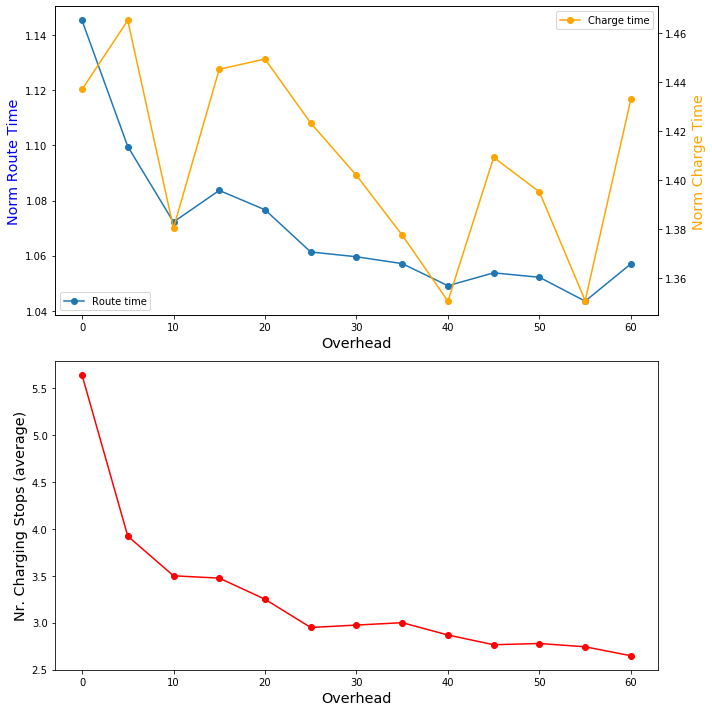

In [116]:
overhead_df = pd.read_csv('overhead_exp1.csv', usecols=[1,2,3,4,5])
overhead_df=overhead_df.drop_duplicates()#subset='ChargeTime')
overhead_df= overhead_df[overhead_df.ChargeTime >0]

overhead_df['NormDriveTime']=pd.concat(
    [overhead_df['DriveTime'][overhead_df['route']==r]/overhead_df['DriveTime'][overhead_df['route']==r].min() for r in overhead_df['route'].unique()])

overhead_df['NormChargeTime']=pd.concat(
    [overhead_df['ChargeTime'][overhead_df['route']==r]/overhead_df['ChargeTime'][overhead_df['route']==r].min() for r in overhead_df['route'].unique()])

rep =overhead_df.groupby('overhead').mean()

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
ax1.plot(rep.index.values, rep.NormDriveTime, 'o-', label='Route time')
ax1.set_xlabel('Overhead', fontsize='x-large')
ax1.set_ylabel('Norm Route Time', fontsize='x-large', color='blue')
ax1.legend(loc='lower left')

ax3 = ax1.twinx()
ax3.plot(rep.index.values, rep.NormChargeTime, 'o-', c='orange', label='Charge time')
ax3.set_ylabel('Norm Charge Time', fontsize='x-large', color='orange')
ax3.legend()

ax2.plot(rep.index.values, rep.stops, 'o-', c ='r')
ax2.set_xlabel('Overhead', fontsize='x-large')
ax2.set_ylabel('Nr. Charging Stops (average)', fontsize='x-large')
plt.tight_layout()

## Summary

In this notebook we have shown how to mathematically model the EVRP using the open source OR-Tools package from Google and the CBC suite. 

We have demonstrated that by using some alternative mathematical tricks such as the big $M$ formulation and Piecewise description of non linear functions using SOS2 constraints, it was possible to get comparable results as those previously obtained using the commercial solver CPLEX. This gives us the advantage to have an open source solution that is free and that gives us no limitations in terms of the number or parameters that we can use in our routing optimization algorithm.

We are, however, still limited by the the distance matrix service from ORS, since the number of destinations we can query is limited to 57. This can be solved, by implementation of the service in our own server. 

By comparing our results with those obtained by ABRP, we can conclude that our approach is very similar and goes in the right direction. A next step is to include pricing information for each charging stop. This can be included in the objective function so that one can also minimize the money costs of the route, together with the time.